In [2]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import permutations

In [3]:
plt.rcParams['figure.figsize'] = (10.0, 5.0)

In [91]:
data = pd.read_csv('./image_data.csv')
print(data.shape)
data = data.drop_duplicates(subset='image', keep="last")
print(data.shape)

(43944, 16)
(43944, 16)


Objective: <br>
to split the data in three parts:
- no labels
- particular labels
- other labels <br>

try to separate correlating (mixed) classes

#### Highly correlating labels:
- roots
- heart
- lungs
- aorta

In [5]:
print(f'Num of no labels users :  {data[data.num_gems == 0].shape}')
data[data.num_gems == 0]['desc'].head()

Num of no labels users :  (25194, 16)


0    Легочные поля прозрачны. Корни легких структур...
1    Легочные поля прозрачны. Корни легких структур...
3    Легочные поля прозрачны. Корни легких структур...
4    Легочные поля прозрачны. Корни легких структур...
5    Легочные поля прозрачны. Корни легких структур...
Name: desc, dtype: object

In [6]:
for comb in permutations(['roots','heart','lungs','aorta'],2):
    print(f' {comb[0]} : 1  {comb[1]}: 0 num images: {data[(data[comb[0]] == 1) & (data[comb[1]] == 0)].image.nunique()}')

 roots : 1  heart: 0 num images: 379
 roots : 1  lungs: 0 num images: 19
 roots : 1  aorta: 0 num images: 24
 heart : 1  roots: 0 num images: 110
 heart : 1  lungs: 0 num images: 104
 heart : 1  aorta: 0 num images: 88
 lungs : 1  roots: 0 num images: 126
 lungs : 1  heart: 0 num images: 480
 lungs : 1  aorta: 0 num images: 128
 aorta : 1  roots: 0 num images: 36
 aorta : 1  heart: 0 num images: 369
 aorta : 1  lungs: 0 num images: 33


#### Heart & Lungs

In [8]:
data[(data['heart'] == 0) & (data['lungs'] == 1)].desc[:5].values

array(['Легочные поля с признаками пневмосклероза. Корни легких фиброзно уплотнены, тяжисты. Диафрагма обычно расположена. Синусы свободны. Сердце не расширено. Аорта уплотнена. ',
       'Легочные поля с признаками пневмосклероза. Корни легких фиброзно уплотнены, тяжисты. Диафрагма обычно расположена. Синусы свободны. Сердце не расширено. Аорта уплотнена. Сколиоз, спондилез.',
       'Легочные поля без очаговых и инфильтративных изменений, с признаками пневмосклероза. Корни легких фиброзно уплотнены, тяжисты. Диафрагма обычно расположена. Синусы свободны. Сердце без особенностей. Аорта уплотнена, дуга склерозирована. ',
       'Легочные поля с признаками пневмосклероза. Корни легких фиброзно уплотнены, тяжисты. Диафрагма обычно расположена. Синусы свободны. Сердце не расширено. Аорта уплотнена. Сколиоз.',
       'Легочные поля с признаками пневмосклероза. Корни легких фиброзно уплотнены, тяжисты. Диафрагма обычно расположена. Синусы свободны. Сердце не расширено. Аорта уплотнена.'],
 

### No gems ( pathology )

estimeted size 4150
final size 2200


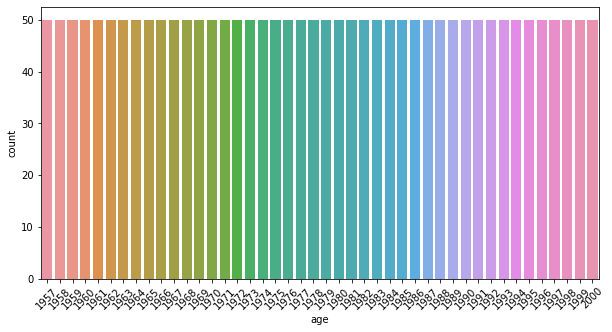

In [93]:
def stratified(data, col, sample, minsize=100, plot=True):
    result = pd.DataFrame()
    groups = data[col].unique()
    print(f'estimeted size {len(groups)*sample}')
    for group in groups:
        size = data[data[col]==group].shape[0]
        if size < minsize:
            continue
        result = result.append(data[data[col]==group].sample(min(size, sample)))
    print(f'final size {result.shape[0]}') 
    if plot:
        plot = sns.countplot(x=col, data=result)
        plot.set_xticklabels(plot.get_xticklabels(), rotation=45);
    return result

no_label = stratified(data[data.num_gems == 0], 'age', 50)

### Lungs separeted

In [94]:
d2 = copy.copy(data[(data['lungs'] == 1) & (data['roots'] == 0)])
d2['label'] = 1
print(d2['image'].nunique())
d3 = copy.copy(data[(data['lungs'] == 1) & (data['heart'] == 0)])
d3['label'] = 1
print(d3['image'].nunique())
d4 = copy.copy(data[(data['lungs'] == 1) & (data['aorta'] == 0)])
d4['label'] = 1
print(d4['image'].nunique())

target_only_lungs = pd.concat([d2,d3,d4])

print(target_only_lungs.shape)
print(target_only_lungs['image'].nunique())

126
480
128
(734, 17)
488


In [95]:
target_only_lungs['num_gems'].hist()

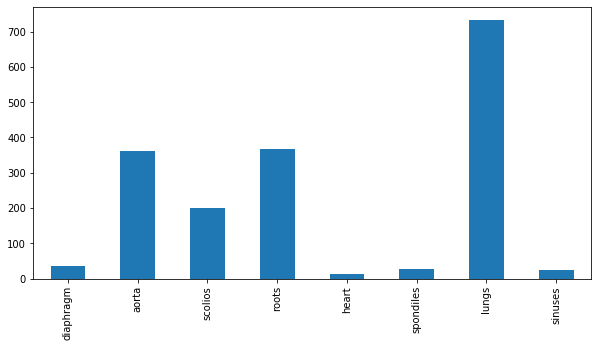

In [96]:
target_only_lungs[gems].sum().plot.bar()

### Lungs + Correlated

estimeted size 1520
final size 560


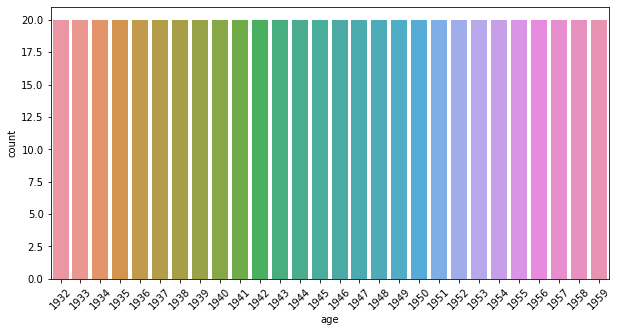

In [97]:
only_lungs_ids = target_only_lungs['image'].to_list()
lungs_and_other = stratified(data[~data.image.isin(only_lungs_ids) & (data.lungs==1)], 'age', 20)

### 560 images Mainly aorta + roots + lungs + heart

In [98]:
lungs_and_other['num_gems'].hist()

In [124]:
lungs_and_other[gems].sum().plot.bar()

In [125]:
target_ids = lungs_and_other['image'].to_list() + only_lungs_ids
print(f' Lungs target ids : {len(set(target_ids))}')

 Lungs target ids : 1048


In [126]:
other = stratified(data[~(data.image.isin(target_ids)) & (data.num_gems != 0) & (data.lungs == 0) ], 'age',10)

estimeted size 800
final size 310


## No LUNGS 

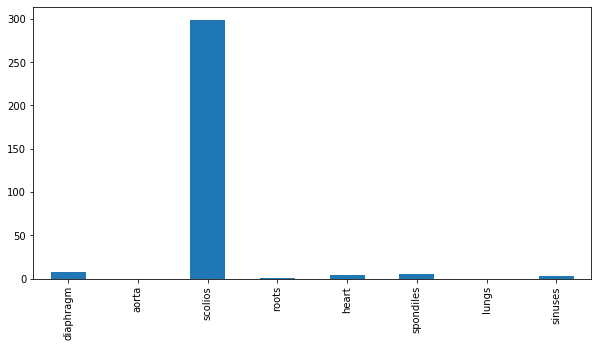

In [123]:
gems = ['diaphragm','aorta', 'scolios', 'roots', 'heart', 'spondiles', 'lungs','sinuses']
other[gems].sum().plot.bar()

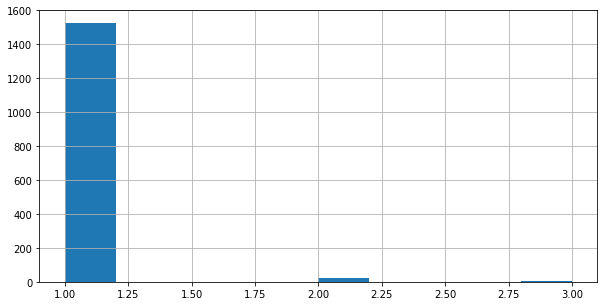

In [111]:
other['num_gems'].hist()

<hr>
Final dataset:

- lungs: 1 + not many of aorta + heart + roots:  488 -- label 1
- lungs: 1 + many aorta + heart + roots 560   -- label 1
    - total lungs label: 1048
- other :  1550  -- label 2 (mainly scolios)
- no labels : 2200   -- label 0

total: 4798

<hr>

In [104]:
# !!! target only lungs doubled


no_label['label'] = 0
lungs_and_other['label'] = 1
target_only_lungs['label'] = 1
other['label'] = 2

final = pd.concat([no_label,lungs_and_other, target_only_lungs, other], sort=False)
final.drop_duplicates('image',inplace=True)
print(final['image'].nunique())
print(final['image'].shape[0])

4598
4598


In [105]:
def stratified_train_test_by_field(data, col, field, sample, minsize=100):
    data['train_test'] = 0
    groups = data[col].unique()
    for group in groups:
        size = data[data[col]==group].shape[0]
        if size < minsize:
            continue
        indices = np.random.choice(data[data[col]==group][field].tolist(), sample)
        #print(data.loc[data[data[field].isin(indices)].index, 'train_test'])
        data.loc[data[data[field].isin(indices)].index, 'train_test'] = 1
    return data

final =  stratified_train_test_by_field(final, 'label', 'user', 150)

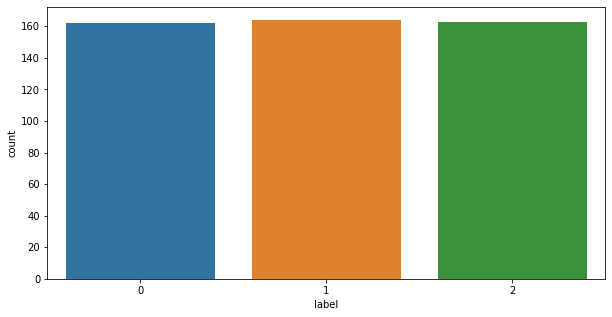

In [29]:
sns.countplot(x='label', data=final[final['train_test']==1])

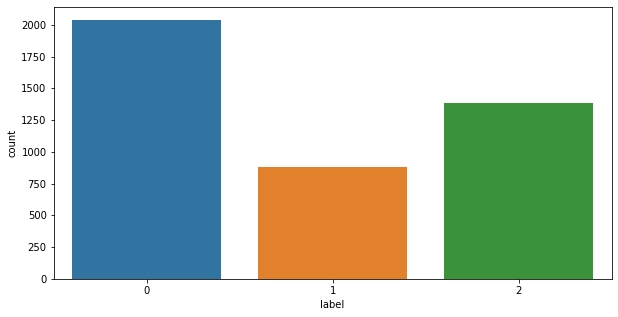

In [30]:
sns.countplot(x='label', data=final[final['train_test']==0])

In [31]:
final[['path','label','train_test','age']].reset_index().drop('index',axis=1).to_csv('./mini_train.csv', index=False)